In [204]:
import numpy as np
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self._prev = _children
        self.grad = .0
        self._op = _op
        self.label=label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1. * out.grad
            other.grad += 1. * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other 

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward

        return out
    
    def relu(self):
        out = Value(max(self.data,0), tuple([self]), 'relu')

        def _backward():
            self.grad += 1 * out.grad if self.data > 0 else 0
        
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * (other**(-1))

    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data**other.data, (self, other), 'pow')
        def _backward():
            self.grad += other.data * (self.data**(other.data - 1)) * out.grad
            other.grad += self.data**other.data * math.log(self.data) * out.grad
        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            visited.add(node)
            for child in node._prev:
                build_topo(child)
            topo.append(node)
            
        build_topo(self)
        self.grad=1.
        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f'{self.label} = {self.data}\t'

    

In [205]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

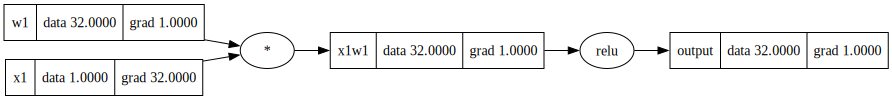

In [206]:
a = Value(1, label='x1')
b = Value(32, label='w1')
c = a*b; c.label='x1w1'
k = c.relu(); k.label = 'output'
k.backward()
draw_dot(k)

In [207]:
import numpy as np
class Tensor():
    def __init__(self, data: np.ndarray, children = (), _op='', label = ''):
        data = np.array(data)
        self._op = _op 
        self.size = data.size
        self.data = data 
        self.label = label
        self._prev = children
        self.grad = np.zeros(self.size)
        self._backward = lambda : None


    def matmul(self, other):
        out = Tensor(data=np.matmul(self.data,other.data), children=(self,other), _op='matmul')
        
        def _backward():
            self.grad += np.matmul(out.grad, np.transpose(other.data))
            other.grad += np.matmul(np.transpose(self.data), out.grad)
        
        out._backward = _backward

        return out

    def __repr__(self):
        s = ''
        for row in self.data:
            s = s + (str(row))
        return '\n'.join(self.data)
    
    

In [208]:
a = Tensor(np.array([4211,43])); a.label = 'a'
b = Tensor(np.array([[1,4],[12,3]])); b.label = 'b'

c = a.matmul(b); c.label = 'c'

In [209]:
a

TypeError: sequence item 0: expected str instance, numpy.int64 found

In [210]:
a.grad

array([0., 0.])

In [211]:
b.grad

array([0., 0., 0., 0.])

In [212]:
c.grad = np.ones(c.size)
c._backward()

In [213]:
a.grad

array([ 5., 15.])

In [214]:
b.grad

array([4254., 4254., 4254., 4254.])

In [215]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = f"{n.label} | {str(n)}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [216]:
draw_dot(c)

TypeError: sequence item 0: expected str instance, numpy.ndarray found